## 📌 GRU 모델을 이용한 망간 가격 예측

### 사용변수 : 광물종합지수, 희유금속지수, 시장전망지표, 무역수지, 환율, 2차전지 산업지수 

In [1]:
#!pip install torchvision

In [2]:
import torch
import torch.nn
import torchvision.transforms as transforms
import torchvision.datasets
from torch.autograd import Variable
from torch.nn import Parameter
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
import math

import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

In [3]:
plt.style.use('seaborn-whitegrid')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

torch.manual_seed(125)

if torch.cuda.is_available() :
    torch.cuda.manual_seed_all(125)

C:\Users\wandong\AppData\Local\Temp\ipykernel_2904\1616429856.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


## 1. 데이터 형태 확인

In [4]:
import pandas as pd
import numpy as np
df=pd.read_csv('../../../../data/final/망간data.csv')
주식=pd.read_csv('../../../../data/final/주식.csv',encoding='cp949')
df=pd.merge(df,주식,left_on='기준일',right_on='Date',how='left')
df=df.iloc[:-2]
df

,기준일,광물종합지수,메이저금속지수,희유금속지수,에너지광물지수,Close,기준가격,시장전망지표,수급안정화지수,수출 중량,...,삼성SDI,LG화학,에코프로비엠,에코프로,sk이노베이션,엘앤에프,코스모신소재,롯데에너지머티리얼즈,솔브레인홀딩스,평균주가
0,2021-06-09,2407.51,2494.11,1682.47,2193.115993,1116.890015,1445.0,49.37,47.48,0.3,...,0.550586,0.818009,0.000000,0.002092,0.889477,0.000000,0.000000,0.328393,0.285927,0.319387
1,2021-06-10,2436.46,2523.49,1682.47,2227.469874,1116.410034,1445.0,49.37,47.48,0.3,...,0.559105,0.827488,0.004433,0.002511,0.863166,0.006937,0.002379,0.322835,0.281459,0.318924
2,2021-06-11,2452.92,2519.40,1682.47,2284.482995,1111.260010,1445.0,49.37,47.48,0.3,...,0.618743,0.909005,0.007149,0.000152,0.889477,0.012713,0.006423,0.338583,0.272524,0.339419
3,2021-06-14,2498.37,2567.59,1741.94,2315.536776,1115.550049,1445.0,49.37,47.48,0.3,...,0.620873,0.865403,0.007209,0.000455,0.905267,0.023114,0.006900,0.348773,0.285182,0.340353
4,2021-06-15,2496.55,2564.67,1741.94,2315.536776,1116.319946,1445.0,49.37,47.48,0.3,...,0.650692,0.852133,0.008213,0.000268,0.963163,0.012300,0.004998,0.354331,0.281459,0.347506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,2024-04-22,2946.21,2545.26,1819.96,3154.139607,1373.930054,1080.0,89.14,85.71,4.1,...,0.157614,0.014218,0.469207,0.380355,0.036372,0.263831,0.615077,0.119963,0.422189,0.275425
749,2024-04-23,2929.48,2546.98,1819.96,3081.062858,1378.839966,1080.0,89.14,85.71,4.1,...,0.126731,0.002844,0.453666,0.380355,0.024605,0.255420,0.594855,0.140806,0.419211,0.266499
750,2024-04-24,2886.01,2500.92,1819.96,3043.299367,1370.479980,1080.0,89.14,85.71,4.1,...,0.158679,0.020853,0.482357,0.380355,0.033163,0.291067,0.610744,0.150533,0.483246,0.290111
751,2024-04-25,2895.92,2521.51,1819.96,3021.949758,1376.969971,1080.0,89.14,85.71,4.1,...,0.140575,0.004739,0.454861,0.399120,0.019791,0.267836,0.600151,0.148680,0.484736,0.280054


In [5]:
df['수급상태'] = pd.cut(df['수급안정화지수'],
                   bins=[-float('inf'), 1, 5, 20, 80, float('inf')],
                   labels=['수급위기', '수급불안', '수급주의', '수급안정', '공급과잉'])
df['수급상태']

0      수급안정
1      수급안정
2      수급안정
3      수급안정
4      수급안정
       ... 
748    공급과잉
749    공급과잉
750    공급과잉
751    공급과잉
752    공급과잉
Name: 수급상태, Length: 753, dtype: category
Categories (5, object): ['수급위기' < '수급불안' < '수급주의' < '수급안정' < '공급과잉']

In [6]:
### 41개의 공휴일값들이 존재해서 이전 값으로 채워줌

In [7]:
df.isna().sum()

기준일            0
광물종합지수         0
메이저금속지수        0
희유금속지수         0
에너지광물지수        0
Close          0
기준가격           0
시장전망지표         0
수급안정화지수        0
수출 중량          0
수출 금액          0
수입 중량          0
수입 금액          0
무역수지           0
Date          41
삼성SDI         41
LG화학          41
에코프로비엠        41
에코프로          41
sk이노베이션       41
엘앤에프          41
코스모신소재        41
롯데에너지머티리얼즈    41
솔브레인홀딩스       41
평균주가          41
수급상태           0
dtype: int64

In [8]:
df[df['삼성SDI'].isna()]

,기준일,광물종합지수,메이저금속지수,희유금속지수,에너지광물지수,Close,기준가격,시장전망지표,수급안정화지수,수출 중량,...,LG화학,에코프로비엠,에코프로,sk이노베이션,엘앤에프,코스모신소재,롯데에너지머티리얼즈,솔브레인홀딩스,평균주가,수급상태
48,2021-08-16,2611.00,2452.16,2041.30,2854.110341,1161.380005,1535.0,32.99,31.72,3.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,수급안정
73,2021-09-20,2638.48,2280.24,2411.36,3337.811379,1181.109985,1765.0,19.87,19.11,10.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,수급주의
74,2021-09-21,2572.47,2184.62,2411.36,3362.248059,1186.319946,1765.0,19.87,19.11,10.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,수급주의
75,2021-09-22,2568.79,2184.37,2411.36,3345.817516,1182.920044,1765.0,19.87,19.11,10.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,수급주의
83,2021-10-04,2801.90,2297.90,2658.27,3948.531138,1180.000000,2335.0,2.73,2.63,39.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,수급불안
88,2021-10-11,2860.25,2371.28,2668.33,3922.334533,1195.579956,2505.0,2.73,2.63,39.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,수급불안
147,2021-12-31,2732.84,2436.65,3050.71,2912.464687,1189.890015,1615.0,2.54,2.44,0.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,수급불안
168,2022-01-31,3155.46,2647.56,3544.16,3834.072139,1207.709961,1685.0,16.46,15.83,26719.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,수급주의
169,2022-02-01,3136.18,2633.95,3544.16,3795.501631,1205.119995,1685.0,17.07,16.41,3.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,수급주의
170,2022-02-02,3127.02,2637.42,3544.16,3743.976388,1202.500000,1685.0,17.07,16.41,3.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,수급주의


In [9]:
주식.head(3)

,Date,삼성SDI,LG화학,에코프로비엠,에코프로,sk이노베이션,엘앤에프,코스모신소재,롯데에너지머티리얼즈,솔브레인홀딩스,평균주가
0,2021-06-09,0.550586,0.818009,0.000000,0.002092,0.889477,0.000000,0.000000,0.328393,0.285927,0.319387
1,2021-06-10,0.559105,0.827488,0.004433,0.002511,0.863166,0.006937,0.002379,0.322835,0.281459,0.318924
2,2021-06-11,0.618743,0.909005,0.007149,0.000152,0.889477,0.012713,0.006423,0.338583,0.272524,0.339419


In [10]:
df.ffill(inplace=True)
df

,기준일,광물종합지수,메이저금속지수,희유금속지수,에너지광물지수,Close,기준가격,시장전망지표,수급안정화지수,수출 중량,...,LG화학,에코프로비엠,에코프로,sk이노베이션,엘앤에프,코스모신소재,롯데에너지머티리얼즈,솔브레인홀딩스,평균주가,수급상태
0,2021-06-09,2407.51,2494.11,1682.47,2193.115993,1116.890015,1445.0,49.37,47.48,0.3,...,0.818009,0.000000,0.002092,0.889477,0.000000,0.000000,0.328393,0.285927,0.319387,수급안정
1,2021-06-10,2436.46,2523.49,1682.47,2227.469874,1116.410034,1445.0,49.37,47.48,0.3,...,0.827488,0.004433,0.002511,0.863166,0.006937,0.002379,0.322835,0.281459,0.318924,수급안정
2,2021-06-11,2452.92,2519.40,1682.47,2284.482995,1111.260010,1445.0,49.37,47.48,0.3,...,0.909005,0.007149,0.000152,0.889477,0.012713,0.006423,0.338583,0.272524,0.339419,수급안정
3,2021-06-14,2498.37,2567.59,1741.94,2315.536776,1115.550049,1445.0,49.37,47.48,0.3,...,0.865403,0.007209,0.000455,0.905267,0.023114,0.006900,0.348773,0.285182,0.340353,수급안정
4,2021-06-15,2496.55,2564.67,1741.94,2315.536776,1116.319946,1445.0,49.37,47.48,0.3,...,0.852133,0.008213,0.000268,0.963163,0.012300,0.004998,0.354331,0.281459,0.347506,수급안정
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,2024-04-22,2946.21,2545.26,1819.96,3154.139607,1373.930054,1080.0,89.14,85.71,4.1,...,0.014218,0.469207,0.380355,0.036372,0.263831,0.615077,0.119963,0.422189,0.275425,공급과잉
749,2024-04-23,2929.48,2546.98,1819.96,3081.062858,1378.839966,1080.0,89.14,85.71,4.1,...,0.002844,0.453666,0.380355,0.024605,0.255420,0.594855,0.140806,0.419211,0.266499,공급과잉
750,2024-04-24,2886.01,2500.92,1819.96,3043.299367,1370.479980,1080.0,89.14,85.71,4.1,...,0.020853,0.482357,0.380355,0.033163,0.291067,0.610744,0.150533,0.483246,0.290111,공급과잉
751,2024-04-25,2895.92,2521.51,1819.96,3021.949758,1376.969971,1080.0,89.14,85.71,4.1,...,0.004739,0.454861,0.399120,0.019791,0.267836,0.600151,0.148680,0.484736,0.280054,공급과잉


In [11]:
df.isna().sum()

기준일           0
광물종합지수        0
메이저금속지수       0
희유금속지수        0
에너지광물지수       0
Close         0
기준가격          0
시장전망지표        0
수급안정화지수       0
수출 중량         0
수출 금액         0
수입 중량         0
수입 금액         0
무역수지          0
Date          0
삼성SDI         0
LG화학          0
에코프로비엠        0
에코프로          0
sk이노베이션       0
엘앤에프          0
코스모신소재        0
롯데에너지머티리얼즈    0
솔브레인홀딩스       0
평균주가          0
수급상태          0
dtype: int64

In [12]:
df.rename(columns={'기준일':'DATE'},inplace=True)
data=df['DATE']
df.set_index('DATE',inplace=True)
# df.drop('Unnamed: 0',axis=1,inplace=True)
df

,광물종합지수,메이저금속지수,희유금속지수,에너지광물지수,Close,기준가격,시장전망지표,수급안정화지수,수출 중량,수출 금액,...,LG화학,에코프로비엠,에코프로,sk이노베이션,엘앤에프,코스모신소재,롯데에너지머티리얼즈,솔브레인홀딩스,평균주가,수급상태
DATE,,,,,,,,,,,,,,,,,,,,,
2021-06-09,2407.51,2494.11,1682.47,2193.115993,1116.890015,1445.0,49.37,47.48,0.3,15.0,...,0.818009,0.000000,0.002092,0.889477,0.000000,0.000000,0.328393,0.285927,0.319387,수급안정
2021-06-10,2436.46,2523.49,1682.47,2227.469874,1116.410034,1445.0,49.37,47.48,0.3,15.0,...,0.827488,0.004433,0.002511,0.863166,0.006937,0.002379,0.322835,0.281459,0.318924,수급안정
2021-06-11,2452.92,2519.40,1682.47,2284.482995,1111.260010,1445.0,49.37,47.48,0.3,15.0,...,0.909005,0.007149,0.000152,0.889477,0.012713,0.006423,0.338583,0.272524,0.339419,수급안정
2021-06-14,2498.37,2567.59,1741.94,2315.536776,1115.550049,1445.0,49.37,47.48,0.3,15.0,...,0.865403,0.007209,0.000455,0.905267,0.023114,0.006900,0.348773,0.285182,0.340353,수급안정
2021-06-15,2496.55,2564.67,1741.94,2315.536776,1116.319946,1445.0,49.37,47.48,0.3,15.0,...,0.852133,0.008213,0.000268,0.963163,0.012300,0.004998,0.354331,0.281459,0.347506,수급안정
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-22,2946.21,2545.26,1819.96,3154.139607,1373.930054,1080.0,89.14,85.71,4.1,51.0,...,0.014218,0.469207,0.380355,0.036372,0.263831,0.615077,0.119963,0.422189,0.275425,공급과잉
2024-04-23,2929.48,2546.98,1819.96,3081.062858,1378.839966,1080.0,89.14,85.71,4.1,51.0,...,0.002844,0.453666,0.380355,0.024605,0.255420,0.594855,0.140806,0.419211,0.266499,공급과잉
2024-04-24,2886.01,2500.92,1819.96,3043.299367,1370.479980,1080.0,89.14,85.71,4.1,51.0,...,0.020853,0.482357,0.380355,0.033163,0.291067,0.610744,0.150533,0.483246,0.290111,공급과잉


In [13]:
df.isna().sum()

광물종합지수        0
메이저금속지수       0
희유금속지수        0
에너지광물지수       0
Close         0
기준가격          0
시장전망지표        0
수급안정화지수       0
수출 중량         0
수출 금액         0
수입 중량         0
수입 금액         0
무역수지          0
Date          0
삼성SDI         0
LG화학          0
에코프로비엠        0
에코프로          0
sk이노베이션       0
엘앤에프          0
코스모신소재        0
롯데에너지머티리얼즈    0
솔브레인홀딩스       0
평균주가          0
수급상태          0
dtype: int64

In [14]:
drop_columns=['기준가격','수출 중량','수출 금액','수입 중량','수입 금액',
             '삼성SDI','LG화학','에코프로비엠','에코프로','sk이노베이션','엘앤에프','코스모신소재',
             '롯데에너지머티리얼즈','솔브레인홀딩스','Date','수급안정화지수','수급상태','메이저금속지수','에너지광물지수']

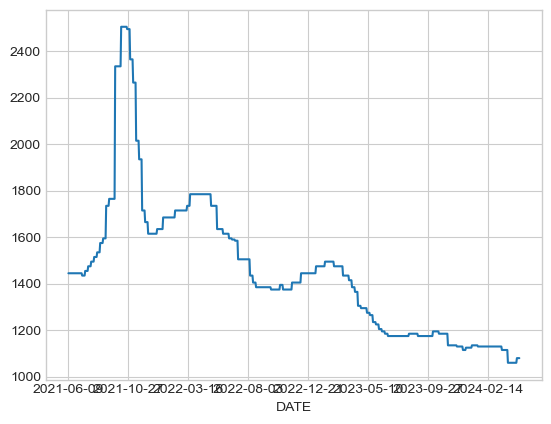

In [15]:
fig = df['기준가격'].plot()

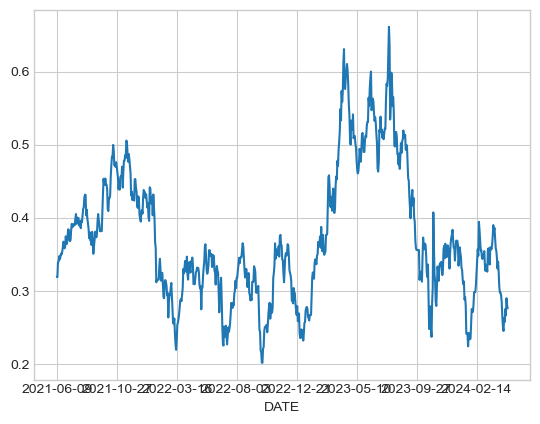

In [16]:
fig = df['평균주가'].plot()

In [17]:
X = df.drop(drop_columns, axis=1) # X, y 분리
y = df[['기준가격']]

In [18]:
y

,기준가격
DATE,
2021-06-09,1445.0
2021-06-10,1445.0
2021-06-11,1445.0
2021-06-14,1445.0
2021-06-15,1445.0
...,...
2024-04-22,1080.0
2024-04-23,1080.0
2024-04-24,1080.0


In [19]:
X.fillna(0,inplace=True)
X.isna().sum()
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 753 entries, 2021-06-09 to 2024-04-26
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   광물종합지수  753 non-null    float64
 1   희유금속지수  753 non-null    float64
 2   Close   753 non-null    float64
 3   시장전망지표  753 non-null    float64
 4   무역수지    753 non-null    float64
 5   평균주가    753 non-null    float64
dtypes: float64(6)
memory usage: 41.2+ KB


In [20]:
X

,광물종합지수,희유금속지수,Close,시장전망지표,무역수지,평균주가
DATE,,,,,,
2021-06-09,2407.51,1682.47,1116.890015,49.37,-19841.0,0.319387
2021-06-10,2436.46,1682.47,1116.410034,49.37,-19841.0,0.318924
2021-06-11,2452.92,1682.47,1111.260010,49.37,-19841.0,0.339419
2021-06-14,2498.37,1741.94,1115.550049,49.37,-19841.0,0.340353
2021-06-15,2496.55,1741.94,1116.319946,49.37,-19841.0,0.347506
...,...,...,...,...,...,...
2024-04-22,2946.21,1819.96,1373.930054,89.14,-15554.0,0.275425
2024-04-23,2929.48,1819.96,1378.839966,89.14,-15554.0,0.266499
2024-04-24,2886.01,1819.96,1370.479980,89.14,-15554.0,0.290111


## 2. 8:2 로 train test 분리

In [21]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

ms = MinMaxScaler() # 0 ~ 1
ss = StandardScaler() # 평균 0, 분산 1

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:746, :] 
X_test = X_ss[746:, :]

y_train = y_ms[:746, :]
y_test = y_ms[746:, :]

print('Training Shape :', X_train.shape, y_train.shape)
print('Testing Shape :', X_test.shape, y_test.shape)

Training Shape : (746, 6) (746, 1)
Testing Shape : (7, 6) (7, 1)


In [22]:
# 데이터셋 형태 및 크기 조정
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors, 
                                  (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))

X_test_tensors_f = torch.reshape(X_test_tensors,
                                (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print('Training Shape :', X_train.shape, y_train.shape)
print('Testing Shape :', X_test.shape, y_test.shape)

Training Shape : (746, 6) (746, 1)
Testing Shape : (7, 6) (7, 1)


## 3. GRU 모델 설정

In [23]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class GRU(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length, dropout_prob=0.0):
        super(GRU, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.dropout = nn.Dropout(p=dropout_prob)  # Dropout layer added
        self.fc = nn.Linear(128, num_classes)
        self.relu = nn.LeakyReLU()

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        output, (hn) = self.gru(x, (h_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.dropout(out)  # Applying dropout before the final fully connected layer
        out = self.fc(out)
        return out


In [24]:
num_epochs = 3000
learning_rate = 0.004
dropout_prob = 0.2

input_size=6
hidden_size=65
num_layers=1

num_classes=1

model=GRU(num_classes,input_size,hidden_size,num_layers,X_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [25]:
for epoch in range(num_epochs) :
    outputs = model.forward(X_train_tensors_f)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors)
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0 :
        print(f'Epoch : {epoch}, loss : {loss.item():1.5f}')

Epoch : 0, loss : 0.06847
Epoch : 100, loss : 0.00141
Epoch : 200, loss : 0.00059
Epoch : 300, loss : 0.00040
Epoch : 400, loss : 0.00033
Epoch : 500, loss : 0.00025
Epoch : 600, loss : 0.00020
Epoch : 700, loss : 0.00020
Epoch : 800, loss : 0.00017
Epoch : 900, loss : 0.00018
Epoch : 1000, loss : 0.00014
Epoch : 1100, loss : 0.00013
Epoch : 1200, loss : 0.00018
Epoch : 1300, loss : 0.00012
Epoch : 1400, loss : 0.00011
Epoch : 1500, loss : 0.00009
Epoch : 1600, loss : 0.00010
Epoch : 1700, loss : 0.00013
Epoch : 1800, loss : 0.00012
Epoch : 1900, loss : 0.00011
Epoch : 2000, loss : 0.00010
Epoch : 2100, loss : 0.00009
Epoch : 2200, loss : 0.00007
Epoch : 2300, loss : 0.00006
Epoch : 2400, loss : 0.00018
Epoch : 2500, loss : 0.00008
Epoch : 2600, loss : 0.00006
Epoch : 2700, loss : 0.00009
Epoch : 2800, loss : 0.00008
Epoch : 2900, loss : 0.00006


In [26]:
df_x_ss = ss.transform(X)
df_y_ms = ms.transform(y)

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

## 4. 예측된 주식 값과 실제 주식 값을 시각화

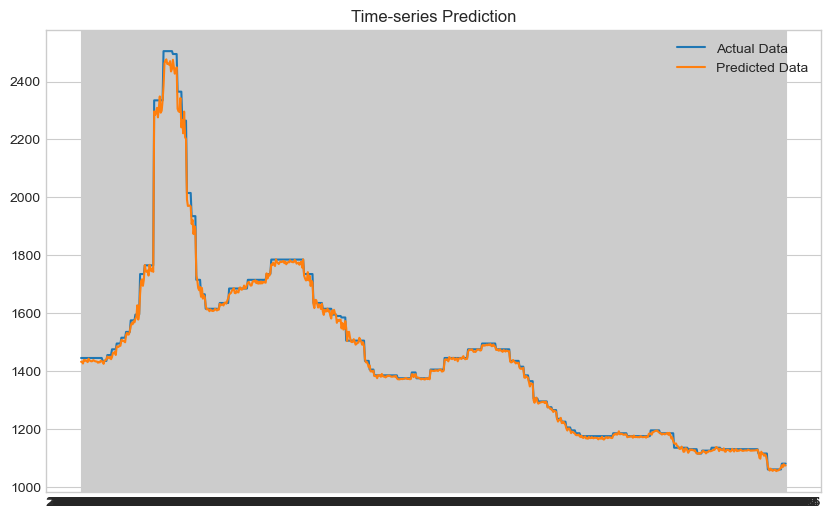

In [27]:
train_predict = model(df_x_ss)
predicted = train_predict.data.numpy()

label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10, 6))
# plt.axvline(x=datetime(2022,5,1), c='r', linestyle='--')

df['pred'] = predicted
plt.plot(df['기준가격'], label='Actual Data')
plt.plot(df['pred'], label='Predicted Data')

plt.title('Time-series Prediction')
plt.legend()
plt.show()

## 5. RMSE 계산

In [28]:
from sklearn.metrics import mean_squared_error
import numpy as np

# 예측값과 실제값을 NumPy 배열로 변환
predicted = np.array(df['pred'])
actual = np.array(df['기준가격'])

# RMSE 계산
rmse = np.sqrt(mean_squared_error(actual, predicted))
print(f'RMSE: {rmse}')


RMSE: 15.815757512346728


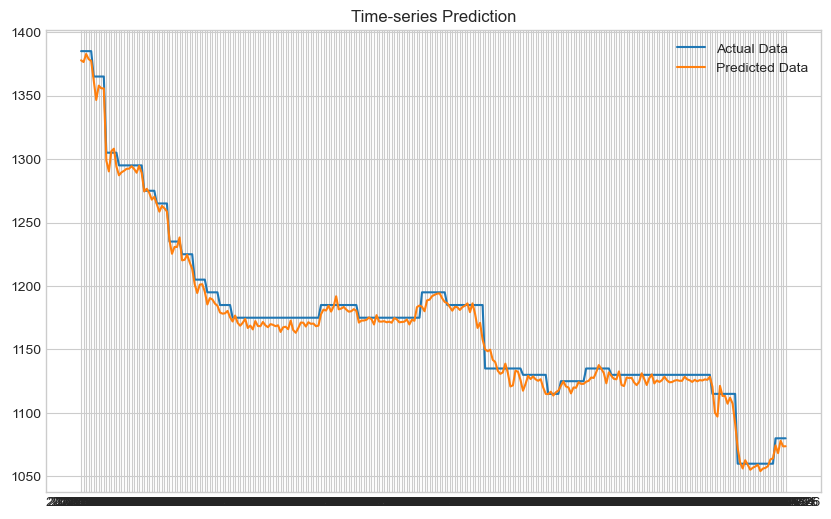

In [29]:
new_df=df.loc['2023-04-01':'2024-04-30']

new_df

plt.figure(figsize=(10, 6))

plt.plot(new_df['기준가격'], label='Actual Data')
plt.plot(new_df['pred'], label='Predicted Data')

plt.title('Time-series Prediction')
plt.legend()
plt.show()

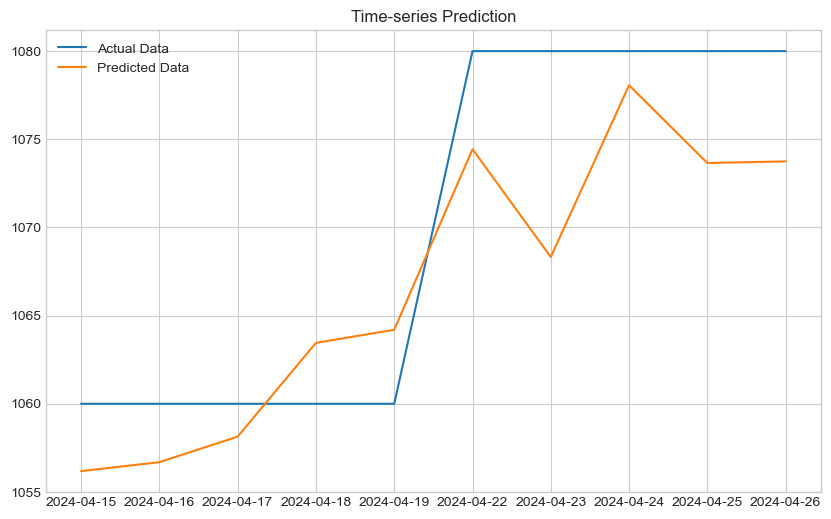

In [30]:
new_df=df.loc['2024-04-15':]

new_df

plt.figure(figsize=(10, 6))

plt.plot(new_df['기준가격'], label='Actual Data')
plt.plot(new_df['pred'], label='Predicted Data')

plt.title('Time-series Prediction')
plt.legend()
plt.show()

## 6. 데이터 내보내기

In [31]:
# 망간LSTM=pd.DataFrame({'DATE':date,'predicted':predicted,'actual':actual})
# 망간LSTM.set_index('DATE',inplace=True)
# HYBE_ALL_LSTM.to_csv('../../../../result/hybe/[LSTM] HYBE.csv',sep=',')
# HYBE_ALL_LSTM

In [32]:
df

,광물종합지수,메이저금속지수,희유금속지수,에너지광물지수,Close,기준가격,시장전망지표,수급안정화지수,수출 중량,수출 금액,...,에코프로비엠,에코프로,sk이노베이션,엘앤에프,코스모신소재,롯데에너지머티리얼즈,솔브레인홀딩스,평균주가,수급상태,pred
DATE,,,,,,,,,,,,,,,,,,,,,
2021-06-09,2407.51,2494.11,1682.47,2193.115993,1116.890015,1445.0,49.37,47.48,0.3,15.0,...,0.000000,0.002092,0.889477,0.000000,0.000000,0.328393,0.285927,0.319387,수급안정,1431.939453
2021-06-10,2436.46,2523.49,1682.47,2227.469874,1116.410034,1445.0,49.37,47.48,0.3,15.0,...,0.004433,0.002511,0.863166,0.006937,0.002379,0.322835,0.281459,0.318924,수급안정,1432.513794
2021-06-11,2452.92,2519.40,1682.47,2284.482995,1111.260010,1445.0,49.37,47.48,0.3,15.0,...,0.007149,0.000152,0.889477,0.012713,0.006423,0.338583,0.272524,0.339419,수급안정,1425.899414
2021-06-14,2498.37,2567.59,1741.94,2315.536776,1115.550049,1445.0,49.37,47.48,0.3,15.0,...,0.007209,0.000455,0.905267,0.023114,0.006900,0.348773,0.285182,0.340353,수급안정,1438.401001
2021-06-15,2496.55,2564.67,1741.94,2315.536776,1116.319946,1445.0,49.37,47.48,0.3,15.0,...,0.008213,0.000268,0.963163,0.012300,0.004998,0.354331,0.281459,0.347506,수급안정,1435.884521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-22,2946.21,2545.26,1819.96,3154.139607,1373.930054,1080.0,89.14,85.71,4.1,51.0,...,0.469207,0.380355,0.036372,0.263831,0.615077,0.119963,0.422189,0.275425,공급과잉,1074.437622
2024-04-23,2929.48,2546.98,1819.96,3081.062858,1378.839966,1080.0,89.14,85.71,4.1,51.0,...,0.453666,0.380355,0.024605,0.255420,0.594855,0.140806,0.419211,0.266499,공급과잉,1068.325073
2024-04-24,2886.01,2500.92,1819.96,3043.299367,1370.479980,1080.0,89.14,85.71,4.1,51.0,...,0.482357,0.380355,0.033163,0.291067,0.610744,0.150533,0.483246,0.290111,공급과잉,1078.066162


In [33]:
# df.to_csv('../../results/망간result.csv',encoding='cp949')